# Exploratory Data Analysis

This notebook is for doing data checks and quick visualizations. 

In [52]:
# standard import
# warnings
import warnings

import duckdb

# geospatial
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from shapely import wkt

warnings.filterwarnings("ignore")

# establish database connections
conn = duckdb.connect("../data/lake/database.duckdb")

## Overview

Load and merge tables. Note that we are using `bright_ti4` as this is used particularly for thermal anomalies and fires. `bright_ti5` is used for cloud and surface temperature measurements.

### Admin boundaries

In [53]:
# download data
!wget -P ../data https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson

--2025-06-08 13:59:20--  https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson
Resolving github.com (github.com)... 20.205.243.166, 64:ff9b::14cd:f3a6
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson [following]
--2025-06-08 13:59:21--  https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/THA/ADM1/geoBoundaries-THA-ADM1_simplified.geojson
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiti

<Axes: >

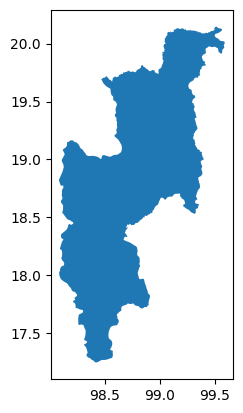

In [54]:
# convert to geodataframe
th_bounds = gpd.read_file("../data/geoBoundaries-THA-ADM1_simplified.geojson")
th_bounds = th_bounds.set_crs(epsg=4326)
provinces = [
    "Chiang Mai Province",
    # "Lamphun Province",
    # "Lampang Province",
    # "Chiang Rai Province",
    # "Mae Hong Son Province"
]
provinces_bounds = th_bounds[th_bounds["shapeName"].isin(provinces)]
provinces_bounds.plot()

### NASA FIRMS

In [55]:
# nasa_firms data
firms_df = conn.sql("""
    SELECT
        acq_datetime,
        (bright_ti4 - 273.15) AS bright_ti4, -- convert to Celsius
        frp,
        geometry
    FROM public.nasa_firms_clean
    WHERE (confidence == 'n' OR confidence == 'h') AND (daynight == 'D')
    """).fetchdf()

firms_df["geometry"] = firms_df["geometry"].apply(wkt.loads)
firms_df = gpd.GeoDataFrame(firms_df, geometry="geometry")
firms_df = firms_df.set_crs(epsg="4326")

firms_df.head(5)

,acq_datetime,bright_ti4,frp,geometry
0,2025-02-01 06:16:00,61.130005,3.27,POINT (99.19873 7.77023)
1,2025-02-01 06:16:00,69.959991,10.58,POINT (99.31365 7.78971)
2,2025-02-01 06:16:00,58.779999,4.03,POINT (99.05454 9.15764)
3,2025-02-01 06:16:00,55.420013,3.33,POINT (98.98035 9.35155)
4,2025-02-01 06:16:00,75.649994,3.48,POINT (99.82351 12.5212)


In [56]:
# intersect with chiang mai bounds
firms_provinces_df = gpd.sjoin(firms_df, provinces_bounds, how="inner")
firms_provinces_df = firms_provinces_df.drop(
    columns=[
        "shapeName",
        "shapeISO",
        "shapeID",
        "shapeGroup",
        "shapeType",
        "index_right",
    ]
)
firms_provinces_df = firms_provinces_df.sort_values(by=["acq_datetime"], ascending=True)
# firms_chiang_mai_df['geometry'] = firms_chiang_mai_df['geometry'].apply(wkt.loads)
firms_provinces_df = gpd.GeoDataFrame(firms_provinces_df, geometry="geometry")
firms_provinces_df = firms_provinces_df.set_crs(epsg=4326)
firms_provinces_df = firms_provinces_df[
    ["acq_datetime", "bright_ti4", "frp", "geometry"]
]
firms_provinces_df = firms_provinces_df[
    (firms_provinces_df["acq_datetime"] >= "2025-02-01")
    & (firms_provinces_df["acq_datetime"] < "2025-04-01")
]

firms_provinces_df.head(5)

,acq_datetime,bright_ti4,frp,geometry
310,2025-02-01 06:18:00,68.490021,6.19,POINT (98.58241 17.60752)
311,2025-02-01 06:18:00,63.800018,6.19,POINT (98.58618 17.60821)
315,2025-02-01 06:18:00,60.450012,2.96,POINT (98.83205 17.77735)
337,2025-02-01 06:18:00,69.950012,3.93,POINT (98.59225 18.18126)
338,2025-02-01 06:18:00,58.209991,3.50,POINT (98.59577 18.18189)


In [57]:
# visualize
firms_provinces_df.explore(
    column="bright_ti4", cmap="viridis", tiles="CartoDB dark_matter"
)

### WAQI

In [58]:
# waqi_airquality data
waqi_df = conn.sql("""
    SELECT *
    FROM public.waqi_airquality_clean
    """).fetchdf()

waqi_df = waqi_df[["date", "pm25"]]
waqi_df = waqi_df[(waqi_df["date"] >= "2025-02-01") & (waqi_df["date"] < "2025-04-01")]
waqi_df = waqi_df.sort_values(by="date", ascending=True)

waqi_df.head(5)

,date,pm25
3963,2025-02-01,87.0
3964,2025-02-02,78.0
3965,2025-02-03,89.0
3966,2025-02-04,110.0
3967,2025-02-05,122.0


## Processing

We want to get:

- average temp of hotspots per day
- number of hotspots per day

In [59]:
firms_date = (
    firms_provinces_df.groupby(firms_provinces_df["acq_datetime"].dt.date)
    .agg({"bright_ti4": "count"})
    .reset_index()
)
firms_date = firms_date.rename(
    columns={"acq_datetime": "date", "bright_ti4": "count_hotspots"}
)
firms_date["date"] = pd.to_datetime(firms_date["date"])
firms_date.head(5)

,date,count_hotspots
0,2025-02-01,6
1,2025-02-02,2
2,2025-02-03,6
3,2025-02-04,3
4,2025-02-05,5


In [60]:
firms_waqi = firms_date.merge(waqi_df, on="date", how="outer")
firms_waqi["count_hotspots"] = firms_waqi["count_hotspots"].fillna(0)
firms_waqi.head(10)

,date,count_hotspots,pm25
0,2025-02-01,6.0,87.0
1,2025-02-02,2.0,78.0
2,2025-02-03,6.0,89.0
3,2025-02-04,3.0,110.0
4,2025-02-05,5.0,122.0
5,2025-02-06,6.0,102.0
6,2025-02-07,4.0,97.0
7,2025-02-08,0.0,120.0
8,2025-02-09,2.0,108.0
9,2025-02-10,9.0,95.0


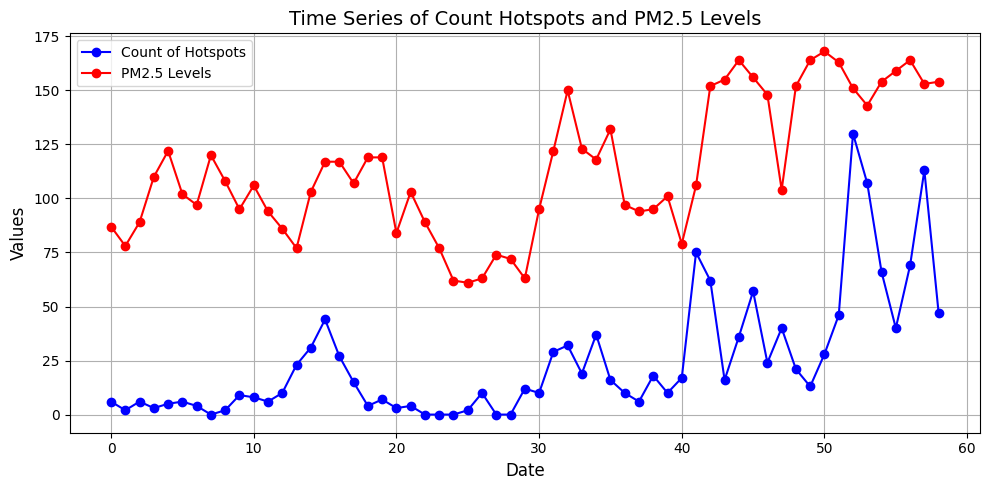

In [61]:
plt.figure(figsize=(10, 5))

plt.plot(
    firms_waqi.index,
    firms_waqi["count_hotspots"],
    label="Count of Hotspots",
    color="blue",
    marker="o",
)
plt.plot(
    firms_waqi.index, firms_waqi["pm25"], label="PM2.5 Levels", color="red", marker="o"
)

plt.title("Time Series of Count Hotspots and PM2.5 Levels", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

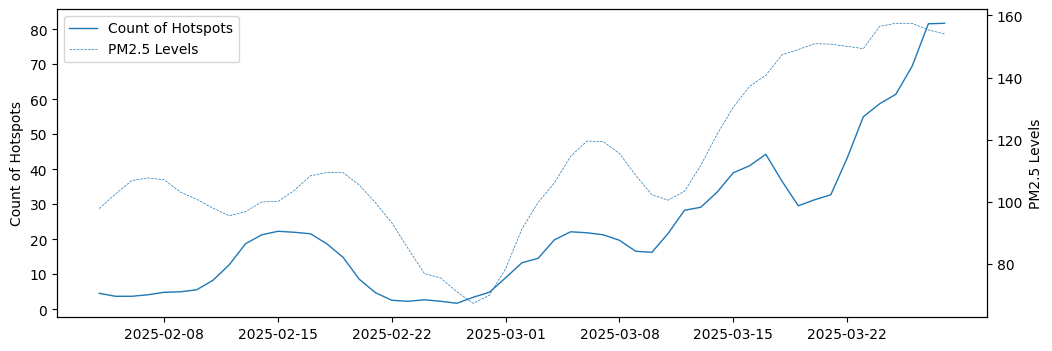

In [67]:
# seasonal decomposition details
seasonal_decompose_model = "additive"  # additive | multiplicative
component = "trend"  # observed | trend | seasonal | resid

# set datetime index to daily
firms_waqi.set_index("date", inplace=True)
firms_waqi = firms_waqi.asfreq("D").fillna(0)
firms_waqi["date"] = firms_waqi.index

plt.figure(figsize=(12, 4))
ax1 = plt.gca()
ax2 = ax1.twinx()

# seasonal decomposition
hotspots_decomposition = sm.tsa.seasonal_decompose(
    firms_waqi["count_hotspots"], model=seasonal_decompose_model
)
hotspots_component = getattr(hotspots_decomposition, component)
ax1.plot(
    hotspots_component.index, hotspots_component, label="Count of Hotspots", linewidth=1
)

pm25_decomposition = sm.tsa.seasonal_decompose(
    firms_waqi["pm25"], model=seasonal_decompose_model
)
pm25_component = getattr(pm25_decomposition, component)
ax2.plot(
    pm25_component.index,
    pm25_component,
    label="PM2.5 Levels",
    linewidth=0.5,
    linestyle="--",
)

ax1.set_ylabel("Count of Hotspots")
ax2.set_ylabel("PM2.5 Levels")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.show()